In [12]:
!pip install antlr4-python3-runtime==4.9.3
!pip install pycocotools==2.0.2
!pip install /kaggle/input/effdet-030-package-dataset/packages/huggingface_hub-0.13.3-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=0544141ec09ca58e62dcc06262f625cff869f2ca7c03c14d435d76ba8da06363
  Stored in directory: /root/.cache/pip/wheels/a9/8b/1f/b8233836d5798e3224c2442947e9639f220095de8bf46e800c
Successfully built antlr4-python3-runtime


In [16]:
import sys
sys.path.insert(0, "../input/effdet-030-package-dataset/packages/")

In [19]:
import effdet

In [20]:
# Basic libraries
import numpy as np
from tqdm.notebook import tqdm

# Draw a sample
import matplotlib.pyplot as pp
import matplotlib.patches as patches

# Make data
from PIL import Image, ImageDraw

# Model and training
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from effdet import EfficientDet, DetBenchTrain, get_efficientdet_config, DetBenchPredict

In [22]:
class CircleDataset(Dataset):
  def __init__(self, use_yxyx=True, image_size=512, bg=(0,0,0), fg=(255,0,0), normalized=True):
    self.use_yxyx = use_yxyx
    self.bg = bg
    self.fg = fg
    self.image_size = image_size

    # augmentation
    self.albu = A.Compose([
        A.RandomResizedCrop(width=self.image_size, height=self.image_size, scale=[0.8, 1.0]),
        A.GaussNoise(p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=5, p=0.5),
        A.OneOf([
             A.CLAHE(clip_limit=2),
             A.Emboss(),
             A.RandomBrightnessContrast(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Normalize(mean=[0.2, 0.1, 0.1], std=[0.2, 0.1, 0.1]) if normalized else None,
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

  def __len__(self):
    return 12 # This function does not make any sense

  def __getitem__(self, idx):
    img = Image.new('RGB', (512, 512), self.bg)

    size = np.random.randint(1, 256)
    left = np.random.randint(0, 256)
    top = np.random.randint(0, 256)

    right = left + size
    bottom = top + size
    draw = ImageDraw.Draw(img)
    draw.ellipse((left, top, right, bottom), fill=self.fg)

    # As an image has one circle, the bounding box is in the shape 1x4 of [x0, y0, x1, y1]
    bboxes = np.array([
        [left, top, right, bottom,],
    ])

    # Labels are attached with bounding boxes, 1 if bounding boxes exist and 0 if don't
    labels = np.array([
        1,
    ])

    result = self.albu(
        image=np.array(img),
        bboxes=bboxes,
        labels=labels,
    )
    x = result['image']
    bboxes = torch.FloatTensor(result['bboxes'])
    labels = torch.FloatTensor(result['labels'])

    # Bounding boxes disappear if they get cropped out in self.albu, and in that case, fill the box and the label with 0
    if bboxes.shape[0] == 0:
        bboxes = torch.zeros([1, 4], dtype=bboxes.dtype)
        labels = torch.FloatTensor(np.array([0]))

    # effdet processes bounding boxes as a form of [y0, x0, y1, x1] and re-indexing is required
    if self.use_yxyx:
        bboxes = bboxes[:, [1, 0, 3, 2]]

    # effdet inputs boxes and labels in the format below
    y = {
        'bbox': bboxes,
        'cls': labels,
    }

    return x, y

In [26]:
# Pass the bounding box data to effdet in the form of [y0, x0, y1, x1]
dataset = CircleDataset(use_yxyx=True)
loader = DataLoader(
  dataset,
  batch_size=4,
  num_workers=2
)

n_epochs = 1

# Load the pre-trained parameters of tf_efficientdet_d0
cfg = get_efficientdet_config(f'tf_efficientdet_d0')
# We have only one class
cfg.num_classes = 1
model = EfficientDet(cfg)
bench = DetBenchTrain(model) # DetBenchTrain is a useful module with a loss function

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

print('Starting training')
for epoch in range(1, n_epochs+1):
  header = f'[{epoch}/{n_epochs}] '

  lr = optimizer.param_groups[0]['lr']
  print(f'{header}Starting lr={lr:.7f}')

  metrics = {
    'loss': [],
  }
  t = tqdm(loader, leave=False)

  for inputs, targets in t:
    inputs = inputs
    targets['bbox'] = targets['bbox']
    targets['cls'] = targets['cls']
    optimizer.zero_grad()
    losses = bench(inputs, targets)
    loss = losses['loss']
    loss.backward()
    optimizer.step()
    iter_metrics = {
      'loss': float(loss.item()),
    }
    message = ' '.join([f'{k}:{v:.4f}' for k, v in iter_metrics.items()])
    t.set_description(f'{header}{message}')
    t.refresh()
    for k, v in iter_metrics.items():
      metrics[k].append(v)
    train_metrics = {k: np.mean(v) for k, v in metrics.items()}
    train_message = ' '.join([f'{k}:{v:.4f}' for k, v in train_metrics.items()])
    print(f'{header}Train: {train_message}')

  # Save the trained parameters every 10 epochs
  if epoch % 10 == 0:
    state = {
      'epoch': epoch,
      'state_dict': model.state_dict(),
    }
    checkpoint_dir = f'weights/b0'
    os.makedirs(checkpoint_dir, exist_ok=True)
    # Save in weights/d0/10.pth
    checkpoint_path = os.path.join(checkpoint_dir, f'{epoch}.pth')
    torch.save(state, checkpoint_path)
    print(f'{header}Saved "{checkpoint_path}"')

  scheduler.step(train_metrics['loss'])
  print()

Starting training
[1/1] Starting lr=0.0001000


  0%|          | 0/3 [00:00<?, ?it/s]

[1/1] Train: loss:30.9208
[1/1] Train: loss:18.7688
[1/1] Train: loss:15.1632



tensor([47.9785, 94.4827, 52.2313, 97.3213,  1.0000,  1.0000])
tensor([ 62.0635, 186.1591,  63.2872, 258.7243,   0.9998,   1.0000])
tensor([-1.1028e+03,  1.8323e+02,  1.4003e+03,  1.8323e+02,  9.9943e-01,
         1.0000e+00])
tensor([  75.3585, -706.9889,   96.9633,  882.3346,    0.9991,    1.0000])
tensor([ 61.4893, 208.9008, 211.1045, 209.2032,   0.9990,   1.0000])
tensor([-74.1673, 242.1781, 579.8864, 242.4004,   0.9979,   1.0000])
tensor([ 37.6956, 170.2254,  43.1267, 182.4497,   0.9976,   1.0000])
tensor([-9.6925e+03,  1.2661e+02,  9.8437e+03,  1.4654e+02,  9.9720e-01,
         1.0000e+00])
tensor([-41.2158, 237.8560,  70.9278, 237.9325,   0.9959,   1.0000])
tensor([-25.8758, 139.7036,  53.4354, 142.6639,   0.9959,   1.0000])
tensor([-2.6643e+03,  1.2903e+02,  2.9988e+03,  1.3030e+02,  9.9367e-01,
         1.0000e+00])
tensor([-118.9334,  375.9049, -118.5019,  419.5799,    0.9925,    1.0000])
tensor([ 34.1824, 171.5876,  52.6355, 177.6953,   0.9859,   1.0000])
tensor([-1.1219e+04

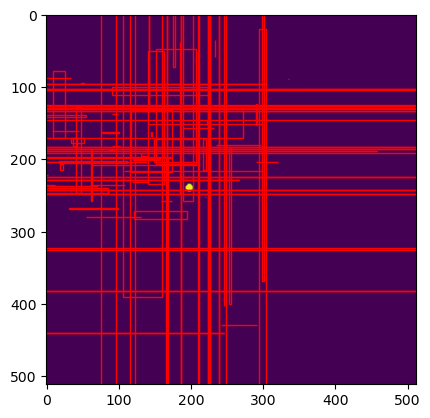

In [28]:
image, targets = dataset.__getitem__(0)
image2 = image.unsqueeze(0)
bench = DetBenchPredict(model)
with torch.no_grad():
  output = bench(image2)

fig, ax = pp.subplots()
ax.imshow(image[0,:,:])

for i in range(output.shape[1]):
  if output[0, i, 4] > 0.5:
    x1 = int(output[0, i, 0])
    y1 = int(output[0, i, 1])
    width = int(output[0, i, 2] - output[0, i, 0])
    height = int(output[0, i, 3] - output[0, i, 1])
    rect = patches.Rectangle((x1, y1), width, height, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    print(output[0,i,:])
    

pp.show()